In [37]:
 # Required: Trained model weights and ESM 2 embedding files for peptide and MHC seq as described in the Training part of the notebook

In [35]:
import pandas as pd
import numpy as np
import os
import random
import matplotlib.pyplot as plt
from tqdm import tqdm
from tensorflow.keras import layers, Model, Input
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score, roc_curve, auc
from sklearn.utils import class_weight, resample, shuffle
from sklearn.model_selection import train_test_split
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import StratifiedKFold
from sklearn.utils import class_weight
import tensorflow as tf

In [17]:
from tensorflow.keras.layers import (
    Input, Embedding, Conv1D, LayerNormalization, Dropout,
    Dense, GlobalAveragePooling1D, GlobalMaxPooling1D,
    MultiHeadAttention, Add, Layer, Activation,SpatialDropout1D
)

In [6]:
data2 = pd.read_csv("MHC2_External_dataset.csv") ## external validation data  194 immunogenic and 253 non immunogenic

data2["Full_sequence"].str.len().value_counts()

Full_sequence
269    447
Name: count, dtype: int64

In [7]:
data2["Immunogenicity"].value_counts()

Immunogenicity
0    253
1    194
Name: count, dtype: int64

In [8]:
data2.columns

Index(['MHC_allele', 'Peptide', 'Immunogenicity', 'rename_MHC_fasta_Name',
       'Pseudo_Sequence', 'Full_sequence'],
      dtype='object')

In [36]:
## generated embedding from the ESM frozen feature extractor notebook file

In [10]:
Esm_peptide = np.load("/BiO/home/jk/Research_MHC/MHC_I/ESM/results/ESM_2_Peptide_seq_external.npy")
Esm_mhc = np.load("/BiO/home/jk/Research_MHC/MHC_I/ESM/results/ESM_2_MHC_seq_external.npy")
labels = np.load("/BiO/home/jk/Research_MHC/MHC_I/ESM/results/Labels_ex_data_447.npy")

In [11]:
Esm_mhc.shape, Esm_peptide.shape, labels.shape

((447, 1280), (447, 1280), (447,))

In [13]:
# Tokenization
a_vocab = 'ACDEFGHIKLMNPQRSTVWYX'
aa_to_idx = {aa: i+1 for i, aa in enumerate(a_vocab)}  # 0 reserved for padding/unknown

pep_len = 15
mhc_len = 269

def tokenize_seq(seq, max_len):
    tokens = [aa_to_idx.get(aa, 0) for aa in seq]
    if len(tokens) < max_len:
        tokens += [0] * (max_len - len(tokens))
    else:
        tokens = tokens[:max_len]
    return tokens

pep_tokens = np.array([tokenize_seq(s, pep_len) for s in data2['Peptide']])
mhc_tokens = np.array([tokenize_seq(s, mhc_len) for s in data2['Full_sequence']])

print("pep_tokens:", pep_tokens.shape)
print("mhc_tokens:", mhc_tokens.shape)

pep_tokens: (447, 15)
mhc_tokens: (447, 269)


In [14]:
def deepHimmune (vocab_size=len(a_vocab)+1,
                            pep_len=pep_len,
                            mhc_len=mhc_len,
                            esm_dim=Esm_peptide.shape[1],
                            embed_dim=16,
                            conv_filters=32,
                            esm_bottleneck=128,
                            num_heads=1,
                            attn_key_dim=32,
                            dropout_rate=0.5,
                            l2_reg=1e-4):
    # Inputs
    pep_input = Input(shape=(pep_len,), dtype=tf.int32, name="pep_input")
    mhc_input = Input(shape=(mhc_len,), dtype=tf.int32, name="mhc_input")
    esm_pep_input = Input(shape=(esm_dim,), dtype=tf.float32, name="esm_pep_input")
    esm_mhc_input = Input(shape=(esm_dim,), dtype=tf.float32, name="esm_mhc_input")
    
    # CCT-like small branch function
    def small_cct_branch(seq_input, seq_len, name):
        # token embedding + spatial dropout
        x = Embedding(input_dim=vocab_size, output_dim=embed_dim, input_length=seq_len,
                      embeddings_regularizer=l2(l2_reg))(seq_input)
        x = SpatialDropout1D(rate=0.2)(x)
        # lightweight conv
        x = Conv1D(conv_filters, kernel_size=3, padding="same", activation="relu",
                   kernel_regularizer=l2(l2_reg))(x)
        # pre-LN + small self-attention
        norm = LayerNormalization()(x)
        attn = MultiHeadAttention(num_heads=num_heads, key_dim=attn_key_dim)(norm, norm)
        attn = Dropout(dropout_rate)(attn)
        out = Add()([x, attn])
        out = LayerNormalization()(out)
        return out
    
    pep_cct = small_cct_branch(pep_input, pep_len, "pep_cct")
    mhc_cct = small_cct_branch(mhc_input, mhc_len, "mhc_cct")
    
    # Cross-attention: peptide queries -> mhc keys/values (light)
    pep_norm = LayerNormalization()(pep_cct)
    mhc_norm = LayerNormalization()(mhc_cct)
    cross = MultiHeadAttention(num_heads=2, key_dim=attn_key_dim)(pep_norm, mhc_norm)
    cross = Dropout(dropout_rate)(cross)
    cross = Add()([pep_cct, cross])
    cross = LayerNormalization()(cross)
    cross = Dropout(dropout_rate)(cross)
    cross_pool = GlobalAveragePooling1D()(cross)  # shape (batch, conv_filters)
    
    # ESM bottleneck (compress frozen precomputed embeddings)
    esm_concat = Concatenate()([esm_pep_input, esm_mhc_input])  # shape (batch, 2560)
    esm_b = Dense(esm_bottleneck, activation="relu", kernel_regularizer=l2(l2_reg))(esm_concat)
    esm_b = Dropout(dropout_rate)(esm_b)
    
    # Fusion
    fusion = Concatenate()([cross_pool, esm_b])  # small dims
    # small fusion attention
    fusion_exp = Lambda(lambda x: tf.expand_dims(x, axis=1))(fusion)
    fusion_norm = LayerNormalization()(fusion_exp)
    fusion_attn = MultiHeadAttention(num_heads=2, key_dim=attn_key_dim)(fusion_norm, fusion_norm)
    fusion_attn = Dropout(dropout_rate)(fusion_attn)
    fusion_attn = Add()([fusion_exp, fusion_attn])
    fusion_attn = Lambda(lambda x: tf.squeeze(x, axis=1))(fusion_attn)
    fusion_attn = LayerNormalization()(fusion_attn)
    fusion_attn = Dropout(dropout_rate)(fusion_attn)
    
    # Final small classifier (single bottleneck)
    x = Dense(128, activation="relu", kernel_regularizer=l2(l2_reg))(fusion_attn)
    x = Dropout(0.5)(x)
    out = Dense(1, activation="sigmoid")(x)
    
    model = Model(inputs=[pep_input, mhc_input, esm_pep_input, esm_mhc_input], outputs=out)
    # compile with gradient clipping
    opt = Adam(learning_rate=5e-4, clipnorm=1.0)
    model.compile(optimizer=opt, loss="binary_crossentropy", metrics=["accuracy"])
    return model


In [19]:
model = deepHimmune()

In [22]:
from tensorflow.keras.models import load_model
from keras_self_attention import SeqSelfAttention

# 2. Load weights from the provided .keras file 
weights_path = "five_fold_model_12_16_Full_seq_MHCII_2.keras"   # model weight in fold 2

# Try to load weights
try:
    model.load_weights(weights_path)
    print("Weights loaded successfully into recreated model.")
except Exception as e:
    print("model.load_weights(...) failed with error:\n", e)
    print("Trying alternative: load the .keras archive with safe deserialization (last resort).")

Weights loaded successfully into recreated model.


/BiO/home/jk/anaconda3/envs/jk_gpu2/lib/python3.11/site-packages/keras/src/saving/saving_lib.py:797: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 126 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [23]:
print(pep_tokens.shape)
print(mhc_tokens.shape)
print(Esm_peptide.shape)
print(Esm_mhc.shape)
print(labels.shape)

(447, 15)
(447, 269)
(447, 1280)
(447, 1280)
(447,)


In [34]:
## Model Prediction without label

In [24]:
X_ext = [
    pep_tokens,
    mhc_tokens,
    Esm_peptide,
    Esm_mhc
]

In [25]:
y_pred_prob = model.predict(X_ext, batch_size=64)



2026-01-27 15:19:23.694144: I external/local_xla/xla/service/service.cc:163] XLA service 0x78bbb80157d0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2026-01-27 15:19:23.694188: I external/local_xla/xla/service/service.cc:171]   StreamExecutor device (0): Quadro RTX 8000, Compute Capability 7.5
2026-01-27 15:19:23.694197: I external/local_xla/xla/service/service.cc:171]   StreamExecutor device (1): Quadro RTX 8000, Compute Capability 7.5
2026-01-27 15:19:23.774447: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2026-01-27 15:19:23.994023: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:473] Loaded cuDNN version 91700


1/7 ━━━━━━━━━━━━━━━━━━━━ 18s 3s/step

I0000 00:00:1769494766.075551 3916348 device_compiler.h:196] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


7/7 ━━━━━━━━━━━━━━━━━━━━ 6s 466ms/step


In [26]:
y_pred = (y_pred_prob > 0.5).astype(int).ravel()

In [30]:
y_pred_prob[:5] ## predictinon probablity

array([[0.8619497 ],
       [0.76042247],
       [0.77831286],
       [0.8036455 ],
       [0.778474  ]], dtype=float32)

In [24]:
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score, precision_score, recall_score, confusion_matrix

In [26]:
auc  = roc_auc_score(labels, y_pred)

In [32]:
auc

0.7396

In [17]:
cm   = confusion_matrix(labels, y_pred)

In [74]:
cm

array([[184,  69],
       [ 43, 151]])

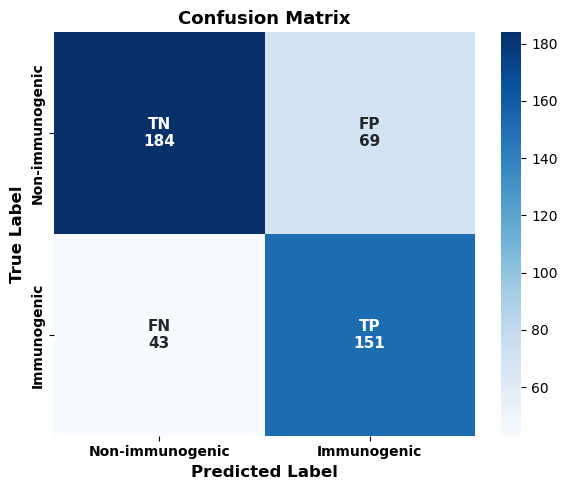

In [23]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(labels, y_pred)

# Labels for TN, FP, FN, TP
group_names = np.array([
    ["TN", "FP"],
    ["FN", "TP"]
])

group_counts = np.array([
    [f"{cm[0,0]}", f"{cm[0,1]}"],
    [f"{cm[1,0]}", f"{cm[1,1]}"]
])

labels = np.array([
    [f"{group_names[0,0]}\n{group_counts[0,0]}",
     f"{group_names[0,1]}\n{group_counts[0,1]}"],
    [f"{group_names[1,0]}\n{group_counts[1,0]}",
     f"{group_names[1,1]}\n{group_counts[1,1]}"]
])

plt.figure(figsize=(6, 5))
ax = sns.heatmap(
    cm,
    annot=labels,
    fmt="",
    cmap="Blues",
    xticklabels=["Non-immunogenic", "Immunogenic"],
    yticklabels=["Non-immunogenic", "Immunogenic"],
    annot_kws={"fontsize": 11, "fontweight": "bold"}
)

# Axis labels (bold)
ax.set_xlabel("Predicted Label", fontsize=12, fontweight="bold")
ax.set_ylabel("True Label", fontsize=12, fontweight="bold")
ax.set_title("Confusion Matrix", fontsize=13, fontweight="bold")

# Make tick labels bold
ax.set_xticklabels(ax.get_xticklabels(), fontsize=10, fontweight="bold")
ax.set_yticklabels(ax.get_yticklabels(), fontsize=10, fontweight="bold")

plt.tight_layout()
plt.show()
